In [1]:
import matplotlib.pyplot as plt
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))

    # --- LOSS ---

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- ACCURACY

    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

In [2]:
import pandas as pd
#Pipline Imports
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from google.cloud import storage
from PIL import Image
import io
import os
import numpy as np

In [3]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

2025-06-06 13:50:14.648853: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-06 13:50:14.671973: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-06 13:50:14.711209: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749217814.757757   35624 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749217814.775334   35624 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749217814.826848   35624 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [4]:
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate

In [5]:
import sys
import os

# Add parent directory to Python path
sys.path.append(os.path.abspath(".."))

# Now you can import the module
import preprocessing
from data import get_metadata_from_bq

In [6]:
metadata = get_metadata_from_bq()

In [7]:
metadata.shape

(10015, 8)

In [8]:
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,index
0,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk,4349
1,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity,4263
2,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk,4217
3,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk,3587
4,HAM_0003350,ISIC_0024310,mel,histo,60.0,male,chest,1451


In [9]:
# Split into nv and non-nv rows
nv_rows = metadata[metadata['dx'] == 'nv']
non_nv_rows = metadata[metadata['dx'] != 'nv']

# Drop duplicates from nv rows based on lesion_id (keeping the first occurrence)
nv_deduped = nv_rows.drop_duplicates(subset='lesion_id', keep='first')

# Combine back
metadata_cleaned = pd.concat([nv_deduped, non_nv_rows], ignore_index=True)

In [10]:
metadata_cleaned.shape

(8713, 8)

In [11]:
processed_metadata = preprocessing.preprocess_metadata(metadata_cleaned)

In [12]:
processed_metadata.shape

(8496, 6)

In [13]:
processed_metadata_small = processed_metadata

In [14]:
#processed_metadata_small.reset_index(drop=True,inplace=True)

In [15]:
processed_metadata_small

,image_id,dx,age,sex,localization,index
0,ISIC_0024306,nv,45.0,male,trunk,4349
1,ISIC_0024307,nv,50.0,male,lower extremity,4263
2,ISIC_0024308,nv,55.0,female,trunk,4217
3,ISIC_0024309,nv,40.0,male,trunk,3587
5403,ISIC_0024310,mel,60.0,male,chest,1451
...,...,...,...,...,...,...
8708,ISIC_0034313,mel,55.0,male,lower extremity,1565
8709,ISIC_0034315,bkl,50.0,male,back,909
8710,ISIC_0034316,mel,85.0,male,upper extremity,1721
8711,ISIC_0034317,mel,70.0,female,lower extremity,1888


In [16]:
client = storage.Client()
bucket = client.bucket("skin_scan_mohnatz")
blobs = bucket.list_blobs(prefix="train_all_images/")
images = [blob.name for blob in blobs if blob.name.lower().endswith(".jpg")]

In [17]:
resized_array = []

In [18]:
for name in processed_metadata_small.image_id:
    for image in images:
        if image.endswith(f"{name}.jpg"):
            blob = bucket.blob(image)
            image_bytes = blob.download_as_bytes()
            img = Image.open(io.BytesIO(image_bytes))
            img = img.resize((96, 96))
            resized_array.append(np.array(img))

In [19]:
X_images = np.array(resized_array)

In [20]:
X_images.shape

(8496, 96, 96, 3)

In [21]:
X_images_copy = X_images.copy()

In [22]:
X_images = X_images/255

In [23]:
processed_metadata_small

,image_id,dx,age,sex,localization,index
0,ISIC_0024306,nv,45.0,male,trunk,4349
1,ISIC_0024307,nv,50.0,male,lower extremity,4263
2,ISIC_0024308,nv,55.0,female,trunk,4217
3,ISIC_0024309,nv,40.0,male,trunk,3587
5403,ISIC_0024310,mel,60.0,male,chest,1451
...,...,...,...,...,...,...
8708,ISIC_0034313,mel,55.0,male,lower extremity,1565
8709,ISIC_0034315,bkl,50.0,male,back,909
8710,ISIC_0034316,mel,85.0,male,upper extremity,1721
8711,ISIC_0034317,mel,70.0,female,lower extremity,1888


In [44]:
round(processed_metadata_small.dx.value_counts(normalize=True)*100,1)

dx
nv       61.5
mel      13.0
bkl      12.7
bcc       6.0
akiec     3.8
vasc      1.7
df        1.4
Name: proportion, dtype: float64

In [24]:
X_metadata, y = preprocessing.prepare_data_for_model(processed_metadata_small)

In [25]:
X_metadata.shape

(8496, 15)

In [26]:
y.shape

(8496, 7)

In [27]:
X_images.shape

(8496, 96, 96, 3)

In [28]:
# Image Branch
image_input = Input(shape=(96, 96, 3))
cnn = Conv2D(16, (6, 6), activation='relu')(image_input)
cnn = Conv2D(32, (3, 3), activation='relu')(cnn)
cnn = Flatten()(cnn)
cnn = Dense(64, activation='relu')(cnn)
cnn = Dense(32, activation='relu')(cnn)

# Metadata Branch
meta_input = Input(shape=(15,))
dln = Dense(16, activation='relu')(meta_input)

# Combined Final Layers
combined_layers = concatenate([cnn, dln])
x = Dense(32, activation='relu')(combined_layers)
output = Dense(7, activation='softmax')(x)

# Define Model
test_model = Model(inputs=[image_input, meta_input], outputs=output)

2025-06-06 14:02:01.531604: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [29]:
test_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy","recall"])

In [30]:
test_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 91, 91,    │      1,744 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 89, 89,    │      4,640 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 253472)    │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │ 16,222,272 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │        256 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 48)        │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      1,568 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 7)         │        231 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,232,791 (61.92 MB)

 Trainable params: 16,232,791 (61.92 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
es = EarlyStopping(patience=10, restore_best_weights=True)

In [32]:
X_images.shape

(8496, 96, 96, 3)

In [33]:
X_metadata.shape

(8496, 15)

In [34]:
X_images_train, X_images_test, X_metadata_train, X_metadata_test, y_train, y_test = train_test_split(
    X_images, X_metadata, y, test_size=0.3, random_state=42
)

In [35]:
X_images_train.shape

(5947, 96, 96, 3)

In [36]:
X_metadata_train.shape

(5947, 15)

In [37]:
y_train.shape

(5947, 7)

In [38]:
history = test_model.fit([X_images_train, X_metadata_train], y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[es])

Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 52s 332ms/step - accuracy: 0.5759 - loss: 1.4196 - recall: 0.4344 - val_accuracy: 0.6168 - val_loss: 1.0112 - val_recall: 0.4294
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 50s 337ms/step - accuracy: 0.6420 - loss: 0.9807 - recall: 0.4902 - val_accuracy: 0.6571 - val_loss: 0.9139 - val_recall: 0.4975
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 50s 335ms/step - accuracy: 0.6667 - loss: 0.8949 - recall: 0.5193 - val_accuracy: 0.6689 - val_loss: 0.9555 - val_recall: 0.4874
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 50s 338ms/step - accuracy: 0.6882 - loss: 0.8326 - recall: 0.5510 - val_accuracy: 0.6681 - val_loss: 0.9374 - val_recall: 0.5437
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 50s 337ms/step - accuracy: 0.7187 - loss: 0.7984 - recall: 0.5737 - val_accuracy: 0.7101 - val_loss: 0.8029 - val_recall: 0.6168
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 51s 340ms/step - accuracy: 0.7252 - loss: 0.7348 - recall: 0.6036 - val_accuracy: 0.7109 - val_loss: 0.7662 -

In [39]:
test_model.evaluate([X_images_test,X_metadata_test],y_test)

80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.7015 - loss: 0.7918 - recall: 0.5515


[0.7778138518333435, 0.7073361873626709, 0.5531581044197083]

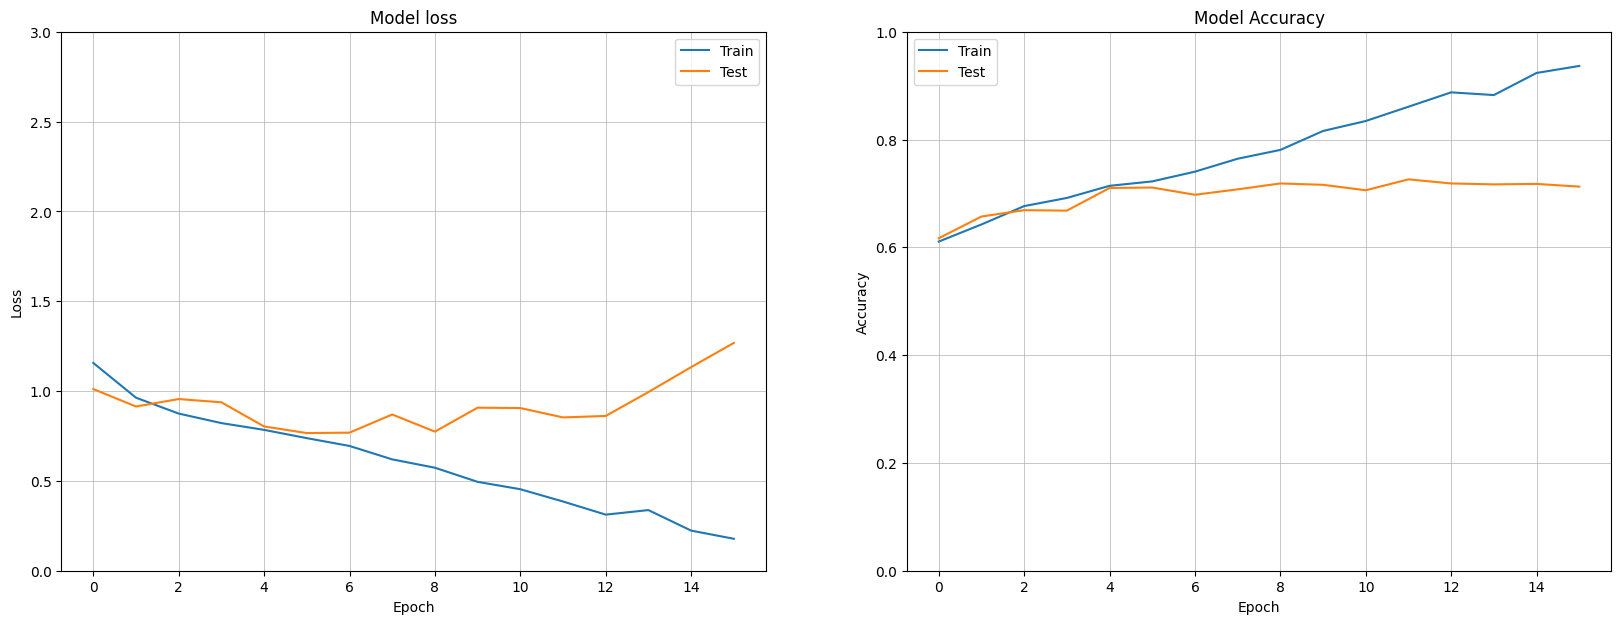

In [40]:
plot_loss_accuracy(history)

In [48]:
test_model.save("96_96_metadata_friday_model.keras")

In [49]:
os.getcwd()

'/home/jupyter/skin_scan/notebooks'

In [50]:
from google.cloud import storage

# Set these before running
bucket_name = "skin_scan_mohnatz"
source_file_name = "96_96_metadata_friday_model.keras"
destination_blob_name = "models/96_96_metadata_friday_model.keras"  # Path in the bucket

# Initialise client (uses default credentials from your environment)
client = storage.Client()
bucket = client.bucket(bucket_name)
blob = bucket.blob(destination_blob_name)

# Upload
blob.upload_from_filename(source_file_name)

print(f"Uploaded {source_file_name} to gs://{bucket_name}/{destination_blob_name}")

Uploaded 96_96_metadata_friday_model.keras to gs://skin_scan_mohnatz/models/96_96_metadata_friday_model.keras


# Image only model

In [76]:
from tensorflow.keras import Sequential, Input, layers

In [77]:
image_model = Sequential()

image_model.add(Input(shape=(96, 96, 3)))
image_model.add(layers.Conv2D(16, (6, 6), padding='same', activation="relu"))
image_model.add(layers.Conv2D(32, (3, 3), padding='same', activation="relu"))
image_model.add(layers.Flatten())
image_model.add(layers.Dense(20, activation='relu'))
image_model.add(layers.Dense(7, activation='softmax'))

In [78]:
image_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 96, 96, 16)     │         1,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 96, 96, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 294912)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 20)             │     5,898,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 7)              │           147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,904,791 (22.52 MB)

 Trainable params: 5,904,791 (22.52 MB)

 Non-trainable params: 0 (0.00 B)

In [79]:
image_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=["accuracy","recall"])

In [39]:
#es = EarlyStopping(patience=10, restore_best_weights=True)

In [81]:
image_history = image_model.fit(X_images_train, y_train,
          epochs=10,  # Use early stopping in practice
          batch_size=32,
          verbose=1,
          validation_split = 0.2)

Epoch 1/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 50s 292ms/step - accuracy: 0.6588 - loss: 1.1631 - recall: 0.5532 - val_accuracy: 0.6769 - val_loss: 0.9780 - val_recall: 0.5146
Epoch 2/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 51s 296ms/step - accuracy: 0.6612 - loss: 0.9642 - recall: 0.5332 - val_accuracy: 0.6711 - val_loss: 0.9074 - val_recall: 0.5395
Epoch 3/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 50s 294ms/step - accuracy: 0.6846 - loss: 0.8590 - recall: 0.5769 - val_accuracy: 0.6959 - val_loss: 0.8701 - val_recall: 0.5863
Epoch 4/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 51s 298ms/step - accuracy: 0.6818 - loss: 0.8793 - recall: 0.5601 - val_accuracy: 0.6915 - val_loss: 0.8537 - val_recall: 0.6294
Epoch 5/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 50s 294ms/step - accuracy: 0.7046 - loss: 0.8111 - recall: 0.6079 - val_accuracy: 0.6279 - val_loss: 0.9364 - val_recall: 0.5424
Epoch 6/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 51s 297ms/step - accuracy: 0.7291 - loss: 0.7502 - recall: 0.6266 - val_accuracy: 0.6937 - val_loss: 0.8257 - val_r

In [45]:
image_model.evaluate(X_images_test,y_test)

NameError: name 'image_model' is not defined